In [2]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.models import KeyedVectors
import pandas as pd
from sklearn.model_selection import cross_val_score, learning_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel,RFE
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN
import warnings
from imblearn.pipeline import Pipeline as imblearn_Pipeline

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# df = pd.read_csv("/content/drive/MyDrive/MS DATA SCIENCE /TESE /data_processed_selected.csv")

In [5]:
df = pd.read_csv("D:\\MS DATA SCIENCE\\NLP TESE\\data\\data_processed_selected.csv")
glove= KeyedVectors.load_word2vec_format('D:\\MS DATA SCIENCE\\NLP TESE\\embeddings\\glove_s600.txt')

In [6]:
import numpy as np
np.random.seed(42)  # Set random seed for numpy

import random
random.seed(42)  # Set random seed for random module

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
# glove= KeyedVectors.load_word2vec_format('/content/drive/MyDrive/MS DATA SCIENCE /TESE /glove_s600.txt')

In [9]:
def preprocess_entities(row):
    if pd.isna(row)==False:
        entities = row.lower()  # Convert to lowercase
        entities = entities.replace(',', '')  # Remove commas
        entities = ' '.join(set(entities.split()))  # Convert to set to get unique values, then join back as a string
        return entities
df['entities'] = df['entities'].apply(preprocess_entities)

In [10]:
y=df['reason']
X = df[['narrative_embeddings', 'embeddings_title', 'embeddings_keywords', 'events_embeddings', 'entities']]

In [11]:
# Split the data into a training set (70%) and a test set (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Print the shape of each set
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (15701, 5)
y_train shape: (15701,)
X_test shape: (6729, 5)
y_test shape: (6729,)


In [12]:
def embeddings_transformation(X, model):
    '''returns the mean of the embeddings of the document X'''
    # initiating a sentence with all zeros
    embedding_size = 600
    X_transformed = np.zeros((len(X), embedding_size))

    # Loop over each string in X
    for i, sentence in enumerate(X):
        # Loop over each word in the sentence and, if it is in the model's vocabulary, add its feature vector to the total
        embeddings = [model[word] for word in sentence.split() if word in model]
        if embeddings:
            X_transformed[i] = np.mean(embeddings, axis=0)
    return X_transformed

In [13]:
feature_set=['narrative_embeddings', 'embeddings_title']
X_train_selected = X_train[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)
# Transform the text data into embeddings
X_train_embeddings = embeddings_transformation(X_train_selected, glove)

In [14]:
def cross_validate_with_pipeline(pipeline, X, y, n_splits=5):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    all_true_labels = []
    all_predicted_labels = []

    for fold, (train_index, val_index) in enumerate(kf.split(X, y), start=1):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

        pipeline.fit(X_train_fold, y_train_fold)

        y_pred_train = pipeline.predict(X_train_fold)
        y_pred_val = pipeline.predict(X_val_fold)

        training_f1_macro = f1_score(y_train_fold, y_pred_train, average='macro')
        validation_f1_macro = f1_score(y_val_fold, y_pred_val, average='macro')

        print(f"Fold number: {fold}, Training F1 Macro: {training_f1_macro:.4f}, Validation F1 Macro: {validation_f1_macro:.4f}")

        all_true_labels.extend(y_val_fold)
        all_predicted_labels.extend(y_pred_val)

    return all_true_labels, all_predicted_labels

In [15]:
def plot_confusion_matrix_and_report(all_true_labels, all_predicted_labels, class_labels):
    # Generate the confusion matrix
    confusion_mat = confusion_matrix(all_true_labels, all_predicted_labels, labels=class_labels)

    # Calculate the classification report
    class_report = classification_report(all_true_labels, all_predicted_labels, target_names=[f'Class {label}' for label in class_labels])

    print("\nClassification Report:")
    print(class_report)

    # Plot the confusion matrix
    print("Confusion Matrix:")
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.matshow(confusion_mat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confusion_mat.shape[0]):
        for j in range(confusion_mat.shape[1]):
            ax.text(x=j, y=i, s=confusion_mat[i, j], va='center', ha='center', size='xx-large')
    plt.xlabel('Predictions', fontsize=10)
    plt.ylabel('Actuals', fontsize=10)
    plt.title('Confusion Matrix', fontsize=10)
    plt.show()
    print('\n')

# LINEARSVC    
was better than XGBOOST in terms of f1-score, by 1%

multiple param_grids because some hyperparameters are not compatible:
* l1 only works with squared_hinge and dual=False
* l2 works with both hinge and squared_hinge, but:
* l2 and hinge only work with dual=True
* l2 and squared_hinge work with both dual=True or dual=False
* dual = True if number of features > number of examples
* C>0

<span style="color:white; font-size:18px;background-color:red"> HYPERPARAMETER TUNING </span>  

In [16]:
# Define multiple hyperparameter grids
param_grid_1 = {
    'classifier__C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'classifier__loss': ['squared_hinge'],
    'classifier__penalty': ['l1'],
    'classifier__dual': [False],
    'classifier__max_iter': [3000, 4000, 5000, 6000, 7000]
}

param_grid_2 = {
    'classifier__C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'classifier__loss': ['hinge'],
    'classifier__penalty': ['l2'],
    'classifier__dual': [True],
    'classifier__max_iter': [3000, 4000, 5000, 6000, 7000]
}

param_grid_3 = {
    'classifier__C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'classifier__loss': ['squared_hinge'],
    'classifier__penalty': ['l2'],
    'classifier__dual': [True, False],
    'classifier__max_iter': [3000, 4000, 5000, 6000, 7000]
}

# Combine the hyperparameter grids into a list
param_grids = [param_grid_1, param_grid_2, param_grid_3]

In [ ]:
model= LinearSVC(random_state=42)
pipeline = Pipeline([
    ('classifier', model)
])

# Define cross-validation strategy (e.g., StratifiedKFold with 5 folds)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grids,
    n_iter=50,
    scoring='f1_macro',
    cv=kf,
    n_jobs=-1,
    random_state=42,
    verbose=3
)

random_search.fit(X_train_embeddings, y_train)
best_model = random_search.best_estimator_
best_params = random_search.best_params_
best_score= random_search.best_score_

print("Best mean cross-validation f1-score: {:.3f}".format(best_score))
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best mean cross-validation f1-score: 0.446
Best Hyperparameters: {'classifier__penalty': 'l1', 'classifier__max_iter': 5000, 'classifier__loss': 'squared_hinge', 'classifier__dual': False, 'classifier__C': 100.0}


Fold number: 1, Training F1 Macro: 0.5083, Validation F1 Macro: 0.4415
Fold number: 2, Training F1 Macro: 0.5035, Validation F1 Macro: 0.4648
Fold number: 3, Training F1 Macro: 0.5043, Validation F1 Macro: 0.4503
Fold number: 4, Training F1 Macro: 0.5123, Validation F1 Macro: 0.4400
Fold number: 5, Training F1 Macro: 0.5063, Validation F1 Macro: 0.4340

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.57      0.64      0.60      5576
     Class 1       0.36      0.06      0.10      1553
     Class 2       0.72      0.83      0.77      7510
     Class 3       0.46      0.23      0.31      1062

    accuracy                           0.65     15701
   macro avg       0.53      0.44      0.45     15701
weighted avg       0.61      0.65      0.61     15701

Confusion Matrix:


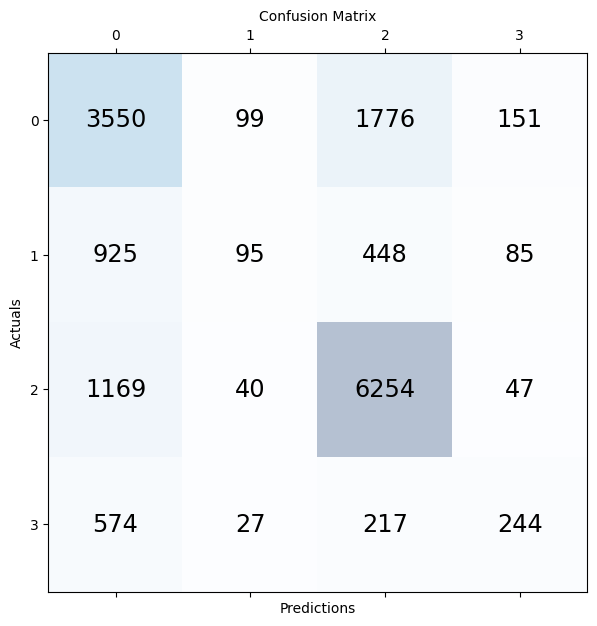

In [ ]:
pipeline = Pipeline([
    ('classifier', best_model.named_steps['classifier'])
])

all_true_labels, all_predicted_labels= cross_validate_with_pipeline(pipeline,X_train_embeddings, y_train, n_splits=5)
plot_confusion_matrix_and_report(all_true_labels, all_predicted_labels, class_labels=[0, 1, 2, 3])

<span style="color:white; font-size:18px;background-color:red"> SMOTE </span>  

Fold number: 1, Training F1 Macro: 0.5384, Validation F1 Macro: 0.4694
Fold number: 2, Training F1 Macro: 0.5328, Validation F1 Macro: 0.4623
Fold number: 3, Training F1 Macro: 0.5307, Validation F1 Macro: 0.4654
Fold number: 4, Training F1 Macro: 0.5362, Validation F1 Macro: 0.4595
Fold number: 5, Training F1 Macro: 0.5282, Validation F1 Macro: 0.4658

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.61      0.37      0.46      5576
     Class 1       0.23      0.37      0.28      1553
     Class 2       0.77      0.75      0.76      7510
     Class 3       0.26      0.57      0.35      1062

    accuracy                           0.57     15701
   macro avg       0.46      0.52      0.46     15701
weighted avg       0.62      0.57      0.58     15701

Confusion Matrix:


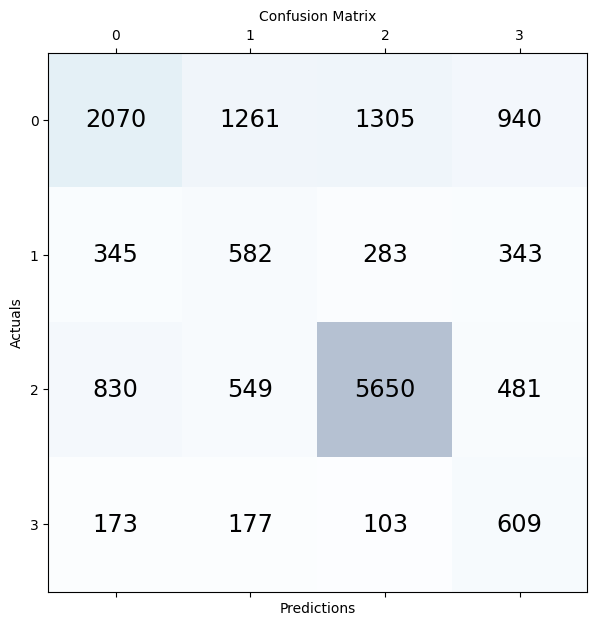

In [ ]:
# Define the SMOTE object
smote=SMOTE(random_state=42, sampling_strategy='not majority')

model= LinearSVC(random_state=42)

# Create an imbalanced-learn Pipeline with SMOTE
pipeline = imblearn_Pipeline([
    ('smote', smote),
    ('classifier', model)
])

all_true_labels, all_predicted_labels = cross_validate_with_pipeline(pipeline, X_train_embeddings, y_train,n_splits=5)
plot_confusion_matrix_and_report(all_true_labels, all_predicted_labels, class_labels=[0, 1, 2, 3])

Fold number: 1, Training F1 Macro: 0.5174, Validation F1 Macro: 0.4456
Fold number: 2, Training F1 Macro: 0.5144, Validation F1 Macro: 0.4581
Fold number: 3, Training F1 Macro: 0.5109, Validation F1 Macro: 0.4406
Fold number: 4, Training F1 Macro: 0.5198, Validation F1 Macro: 0.4515
Fold number: 5, Training F1 Macro: 0.5038, Validation F1 Macro: 0.4421

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.61      0.29      0.39      5576
     Class 1       0.22      0.40      0.28      1553
     Class 2       0.76      0.77      0.77      7510
     Class 3       0.24      0.60      0.35      1062

    accuracy                           0.55     15701
   macro avg       0.46      0.52      0.45     15701
weighted avg       0.62      0.55      0.56     15701

Confusion Matrix:


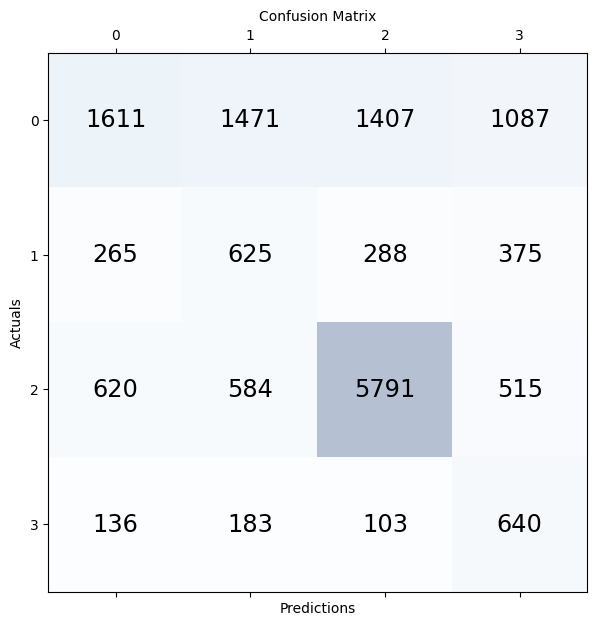

In [31]:
# Define the SMOTE object
smote=ADASYN(random_state=42, sampling_strategy='not majority')

model= LinearSVC(random_state=42)

# Create an imbalanced-learn Pipeline with SMOTE
pipeline = imblearn_Pipeline([
    ('smote', smote),
    ('classifier', model)
])

all_true_labels, all_predicted_labels = cross_validate_with_pipeline(pipeline, X_train_embeddings, y_train,n_splits=5)
plot_confusion_matrix_and_report(all_true_labels, all_predicted_labels, class_labels=[0, 1, 2, 3])

<span style="color:white; font-size:18px;background-color:red"> SMOTE + HT </span>  

In [ ]:
# Define the SMOTE object
smote=SMOTE(random_state=42, sampling_strategy='not majority')

# Define the model with hyperparameter search space
model = LinearSVC(random_state=42)

# Create an imbalanced-learn Pipeline with SMOTE
pipeline = imblearn_Pipeline([
    ('smote', smote),
    ('classifier', model)
])

# Define cross-validation strategy (e.g., StratifiedKFold with 5 folds)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grids,
    scoring='f1_macro',
    cv=kf,
    n_iter=50,
    random_state=42,
    n_jobs=-1,
    verbose=3
)

# Fit the RandomizedSearchCV on your data
random_search.fit(X_train_embeddings, y_train)
best_model = random_search.best_estimator_
best_params = random_search.best_params_
best_score= random_search.best_score_

print("Best mean cross-validation f1-score: {:.3f}".format(best_score))
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best mean cross-validation f1-score: 0.467
Best Hyperparameters: {'classifier__penalty': 'l2', 'classifier__max_iter': 5000, 'classifier__loss': 'squared_hinge', 'classifier__dual': True, 'classifier__C': 0.1}


Fold number: 1, Training F1 Macro: 0.5106, Validation F1 Macro: 0.4572
Fold number: 2, Training F1 Macro: 0.5040, Validation F1 Macro: 0.4649
Fold number: 3, Training F1 Macro: 0.5080, Validation F1 Macro: 0.4745
Fold number: 4, Training F1 Macro: 0.5115, Validation F1 Macro: 0.4677
Fold number: 5, Training F1 Macro: 0.5006, Validation F1 Macro: 0.4719

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.61      0.34      0.44      5576
     Class 1       0.24      0.38      0.29      1553
     Class 2       0.76      0.78      0.77      7510
     Class 3       0.26      0.62      0.37      1062

    accuracy                           0.57     15701
   macro avg       0.47      0.53      0.47     15701
weighted avg       0.62      0.57      0.58     15701

Confusion Matrix:


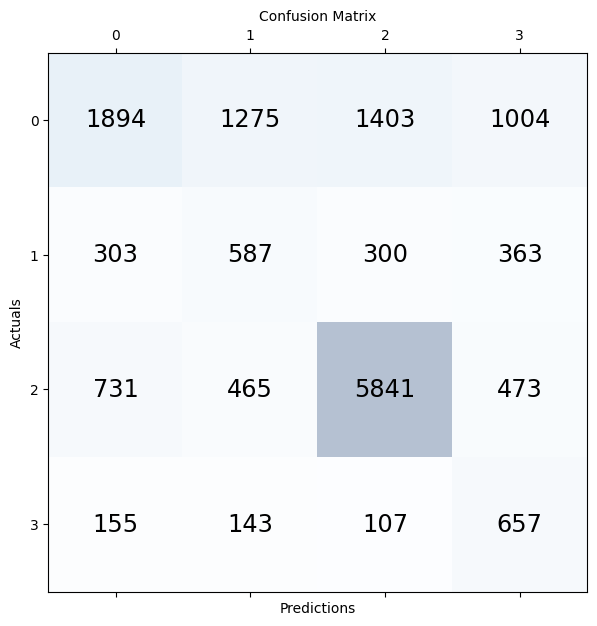

In [ ]:
pipeline = imblearn_Pipeline([
    ('smote', smote),
    ('classifier', best_model.named_steps['classifier'])
])

all_true_labels, all_predicted_labels = cross_validate_with_pipeline(pipeline, X_train_embeddings, y_train, n_splits=5)
plot_confusion_matrix_and_report(all_true_labels, all_predicted_labels, class_labels=[0, 1, 2, 3])

<span style="color:white; font-size:18px;background-color:red"> CLASS WEIGHTS </span>  

Fold number: 1, Training F1 Macro: 0.5606, Validation F1 Macro: 0.4932
Fold number: 2, Training F1 Macro: 0.5593, Validation F1 Macro: 0.4841
Fold number: 3, Training F1 Macro: 0.5591, Validation F1 Macro: 0.4838
Fold number: 4, Training F1 Macro: 0.5641, Validation F1 Macro: 0.4854
Fold number: 5, Training F1 Macro: 0.5577, Validation F1 Macro: 0.5146

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.60      0.53      0.56      5576
     Class 1       0.27      0.21      0.23      1553
     Class 2       0.76      0.79      0.77      7510
     Class 3       0.32      0.53      0.40      1062

    accuracy                           0.62     15701
   macro avg       0.49      0.51      0.49     15701
weighted avg       0.62      0.62      0.62     15701

Confusion Matrix:


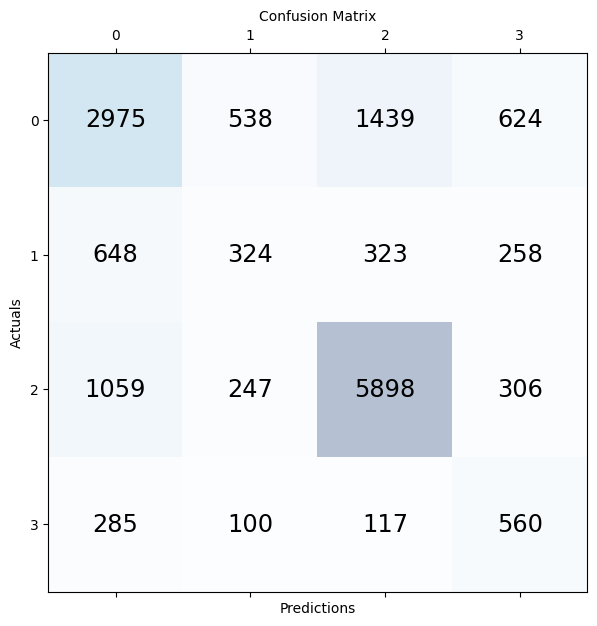

In [ ]:
model= LinearSVC(class_weight='balanced', random_state=42)
pipeline = Pipeline([
    ('classifier', model)
])

all_true_labels, all_predicted_labels= cross_validate_with_pipeline(pipeline,X_train_embeddings, y_train, n_splits=5)
plot_confusion_matrix_and_report(all_true_labels, all_predicted_labels, class_labels=[0, 1, 2, 3])

<span style="color:white; font-size:18px;background-color:red"> CLASS WEIGHTS + HT</span>  

In [ ]:
model= LinearSVC(class_weight='balanced',random_state=42)
pipeline = Pipeline([
    ('classifier', model)
])

# Define cross-validation strategy (e.g., StratifiedKFold with 5 folds)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grids,
    n_iter=50,
    scoring='f1_macro',
    cv=kf,
    n_jobs=-1,
    random_state=42,
    verbose=3
)

random_search.fit(X_train_embeddings, y_train)
best_model = random_search.best_estimator_
best_params = random_search.best_params_
best_score= random_search.best_score_

print("Best mean cross-validation f1-score: {:.3f}".format(best_score))
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best mean cross-validation f1-score: 0.492
Best Hyperparameters: {'classifier__penalty': 'l2', 'classifier__max_iter': 4000, 'classifier__loss': 'squared_hinge', 'classifier__dual': False, 'classifier__C': 1.0}


Fold number: 1, Training F1 Macro: 0.5606, Validation F1 Macro: 0.4930
Fold number: 2, Training F1 Macro: 0.5593, Validation F1 Macro: 0.4847
Fold number: 3, Training F1 Macro: 0.5590, Validation F1 Macro: 0.4841
Fold number: 4, Training F1 Macro: 0.5641, Validation F1 Macro: 0.4856
Fold number: 5, Training F1 Macro: 0.5572, Validation F1 Macro: 0.5139

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.60      0.53      0.56      5576
     Class 1       0.27      0.21      0.23      1553
     Class 2       0.76      0.79      0.77      7510
     Class 3       0.32      0.53      0.40      1062

    accuracy                           0.62     15701
   macro avg       0.49      0.51      0.49     15701
weighted avg       0.62      0.62      0.62     15701

Confusion Matrix:


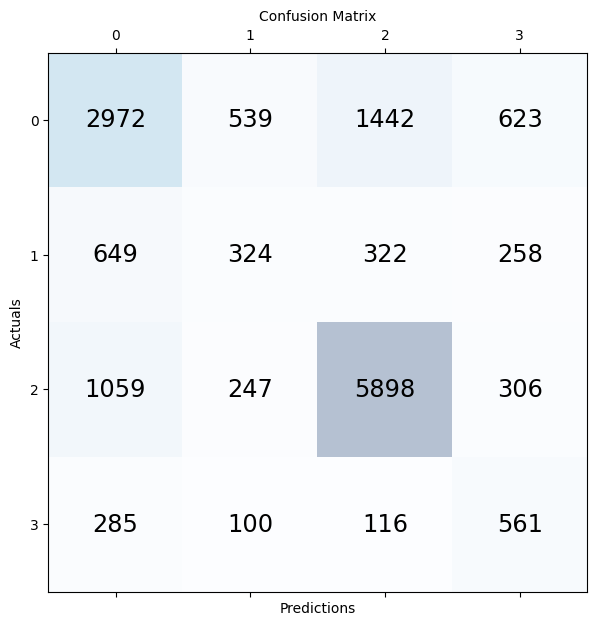

In [ ]:
pipeline = Pipeline([
    ('classifier', best_model.named_steps['classifier'])
])

all_true_labels, all_predicted_labels = cross_validate_with_pipeline(pipeline, X_train_embeddings, y_train, n_splits=5)
plot_confusion_matrix_and_report(all_true_labels, all_predicted_labels, class_labels=[0, 1, 2, 3])

<span style="color:white; font-size:18px;background-color:red"> SMOTE + CLASS WEIGHTS + HT</span>  

In [15]:
# Define the SMOTE object
smote=SMOTE(random_state=42, sampling_strategy='not majority')

# Define the model with hyperparameter search space
model= LinearSVC(class_weight='balanced',random_state=42)

# Create an imbalanced-learn Pipeline with SMOTE
pipeline = imblearn_Pipeline([
    ('smote', smote),
    ('classifier', model)
])

# Define cross-validation strategy (e.g., StratifiedKFold with 5 folds)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grids,
    scoring='f1_macro',
    cv=kf,
    n_iter=50,
    random_state=42,
    n_jobs=-1,
    verbose=3
)

# Fit the RandomizedSearchCV on your data
random_search.fit(X_train_embeddings, y_train)
best_model = random_search.best_estimator_
best_params = random_search.best_params_
best_score= random_search.best_score_

print("Best mean cross-validation f1-score: {:.3f}".format(best_score))
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best mean cross-validation f1-score: 0.467
Best Hyperparameters: {'classifier__penalty': 'l2', 'classifier__max_iter': 7000, 'classifier__loss': 'squared_hinge', 'classifier__dual': False, 'classifier__C': 0.1}


Fold number: 1, Training F1 Macro: 0.5105, Validation F1 Macro: 0.4572
Fold number: 2, Training F1 Macro: 0.5043, Validation F1 Macro: 0.4652
Fold number: 3, Training F1 Macro: 0.5079, Validation F1 Macro: 0.4746
Fold number: 4, Training F1 Macro: 0.5116, Validation F1 Macro: 0.4674
Fold number: 5, Training F1 Macro: 0.5005, Validation F1 Macro: 0.4719

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.61      0.34      0.44      5576
     Class 1       0.24      0.38      0.29      1553
     Class 2       0.76      0.78      0.77      7510
     Class 3       0.26      0.62      0.37      1062

    accuracy                           0.57     15701
   macro avg       0.47      0.53      0.47     15701
weighted avg       0.62      0.57      0.58     15701

Confusion Matrix:


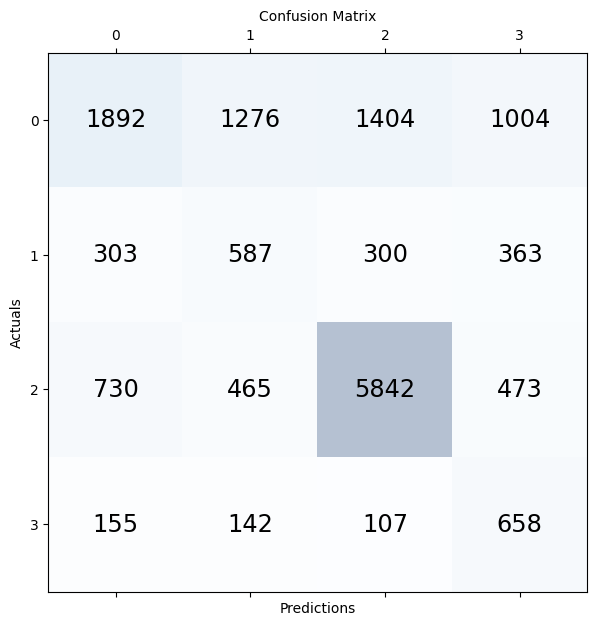

In [16]:
pipeline = imblearn_Pipeline([
    ('smote', smote),
    ('classifier', best_model.named_steps['classifier'])
])

all_true_labels, all_predicted_labels = cross_validate_with_pipeline(pipeline, X_train_embeddings, y_train, n_splits=5)
plot_confusion_matrix_and_report(all_true_labels, all_predicted_labels, class_labels=[0, 1, 2, 3])

<span style="color:white; font-size:18px;background-color:red"> L1 REGULARIZATION </span>  

In [22]:
X_train_embeddings.shape

(15701, 600)

Fold number: 1, Training F1 Macro: 0.4633, Validation F1 Macro: 0.4304
Fold number: 2, Training F1 Macro: 0.4523, Validation F1 Macro: 0.4318
Fold number: 3, Training F1 Macro: 0.4616, Validation F1 Macro: 0.4192
Fold number: 4, Training F1 Macro: 0.4624, Validation F1 Macro: 0.4205
Fold number: 5, Training F1 Macro: 0.4661, Validation F1 Macro: 0.4129
Number of features after: 528

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.57      0.66      0.61      5576
     Class 1       0.41      0.03      0.05      1553
     Class 2       0.72      0.85      0.78      7510
     Class 3       0.49      0.17      0.25      1062

    accuracy                           0.65     15701
   macro avg       0.55      0.42      0.42     15701
weighted avg       0.62      0.65      0.61     15701

Confusion Matrix:


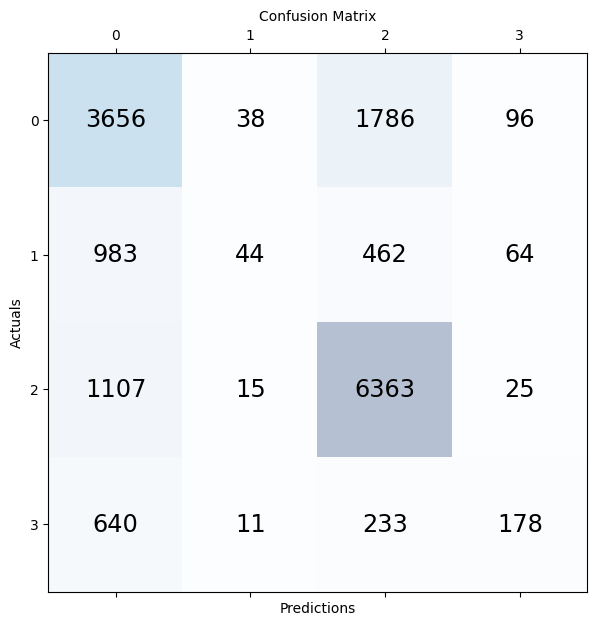

In [25]:
# Initialize the LinearSVC model with L1 regularization for feature selection
l1_svc = LinearSVC(penalty='l1', dual=False, random_state=42)

# Create a pipeline with feature selection and classification steps
pipeline = Pipeline([
    ('feature_selection', SelectFromModel(estimator=l1_svc)),
    ('classification', LinearSVC(random_state=42))
])

all_true_labels, all_predicted_labels = cross_validate_with_pipeline(pipeline, X_train_embeddings, y_train, n_splits=5)

selected_features = pipeline.named_steps['feature_selection'].get_support()
num_selected_features = np.sum(selected_features)
print(f'Number of features after: {num_selected_features}')

plot_confusion_matrix_and_report(all_true_labels, all_predicted_labels, class_labels=[0, 1, 2, 3])

<span style="color:white; font-size:18px;background-color:red"> L1 REGULARIZATION + HT </span>  

In [17]:
# Initialize the LinearSVC model with L1 regularization for feature selection
l1_svc = LinearSVC(penalty='l1', dual=False, random_state=42)

# Create a pipeline with feature selection and classification steps
pipeline = Pipeline([
    ('feature_selection', SelectFromModel(estimator=l1_svc)),
    ('classifier', LinearSVC(random_state=42))
])

# Define cross-validation strategy (e.g., StratifiedKFold with 5 folds)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grids,
    n_iter=50,  
    scoring='f1_macro', 
    cv=kf,
    n_jobs=-1, 
    random_state=42,
    verbose=3
)

random_search.fit(X_train_embeddings, y_train)
best_model = random_search.best_estimator_
best_params = random_search.best_params_
best_score= random_search.best_score_

print("Best mean cross-validation f1-score: {:.3f}".format(best_score))
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best mean cross-validation f1-score: 0.445
Best Hyperparameters: {'classifier__penalty': 'l2', 'classifier__max_iter': 6000, 'classifier__loss': 'squared_hinge', 'classifier__dual': True, 'classifier__C': 100.0}


In [18]:
best_model.named_steps['feature_selection']

SelectFromModel(estimator=LinearSVC(dual=False, penalty='l1', random_state=42))

In [20]:
best_model.named_steps['classifier']

LinearSVC(C=100.0, max_iter=6000, random_state=42)

Fold number: 1, Training F1 Macro: 0.5318, Validation F1 Macro: 0.4593
Fold number: 2, Training F1 Macro: 0.5350, Validation F1 Macro: 0.4723
Fold number: 3, Training F1 Macro: 0.4705, Validation F1 Macro: 0.4267
Fold number: 4, Training F1 Macro: 0.5268, Validation F1 Macro: 0.4508
Fold number: 5, Training F1 Macro: 0.4784, Validation F1 Macro: 0.4159

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.57      0.60      0.59      5576
     Class 1       0.35      0.08      0.13      1553
     Class 2       0.71      0.83      0.76      7510
     Class 3       0.42      0.25      0.31      1062

    accuracy                           0.64     15701
   macro avg       0.51      0.44      0.45     15701
weighted avg       0.60      0.64      0.61     15701

Confusion Matrix:


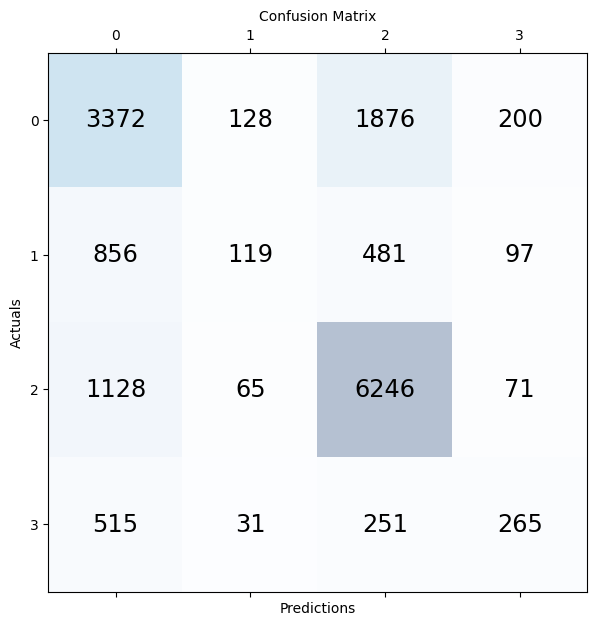

In [19]:
# Create a pipeline with feature selection and classification steps
pipeline = Pipeline([
    ('feature_selection', SelectFromModel(estimator=l1_svc)),
    ('classifier', best_model.named_steps['classifier'])
])

all_true_labels, all_predicted_labels = cross_validate_with_pipeline(pipeline, X_train_embeddings, y_train, n_splits=5)
plot_confusion_matrix_and_report(all_true_labels, all_predicted_labels, class_labels=[0, 1, 2, 3])

<span style="color:white; font-size:18px;background-color:red"> CLASS WEIGHTS + SMOTE </span>  

Fold number: 1, Training F1 Macro: 0.5384, Validation F1 Macro: 0.4694
Fold number: 2, Training F1 Macro: 0.5328, Validation F1 Macro: 0.4623
Fold number: 3, Training F1 Macro: 0.5307, Validation F1 Macro: 0.4654
Fold number: 4, Training F1 Macro: 0.5362, Validation F1 Macro: 0.4595
Fold number: 5, Training F1 Macro: 0.5282, Validation F1 Macro: 0.4658

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.61      0.37      0.46      5576
     Class 1       0.23      0.37      0.28      1553
     Class 2       0.77      0.75      0.76      7510
     Class 3       0.26      0.57      0.35      1062

    accuracy                           0.57     15701
   macro avg       0.46      0.52      0.46     15701
weighted avg       0.62      0.57      0.58     15701

Confusion Matrix:


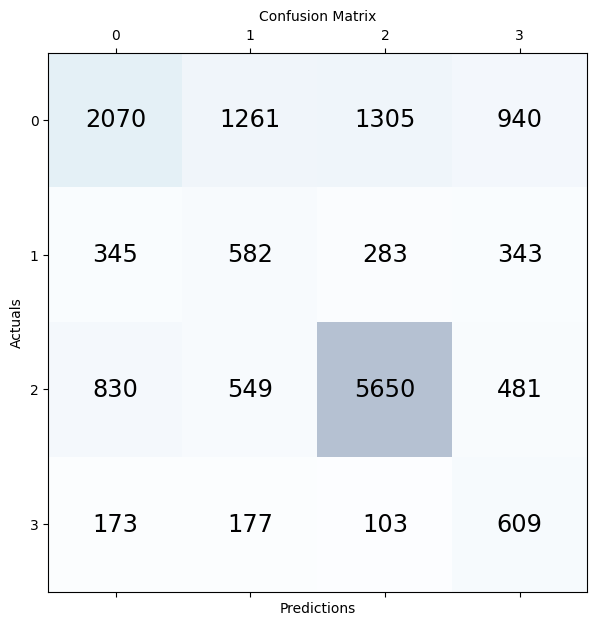

In [23]:
# Define the SMOTE object
smote=SMOTE(random_state=42, sampling_strategy='not majority')

# Define the model with hyperparameter search space
model= LinearSVC(class_weight='balanced',random_state=42)

# Create an imbalanced-learn Pipeline with SMOTE
pipeline = imblearn_Pipeline([
    ('smote', smote),
    ('classifier', model)
])

all_true_labels, all_predicted_labels = cross_validate_with_pipeline(pipeline, X_train_embeddings, y_train, n_splits=5)
plot_confusion_matrix_and_report(all_true_labels, all_predicted_labels, class_labels=[0, 1, 2, 3])

<span style="color:white; font-size:18px;background-color:red"> CLASS WEIGHTS + L1 REGULARIZATION </span>  

Fold number: 1, Training F1 Macro: 0.5591, Validation F1 Macro: 0.4937
Fold number: 2, Training F1 Macro: 0.5563, Validation F1 Macro: 0.4803
Fold number: 3, Training F1 Macro: 0.5557, Validation F1 Macro: 0.4892
Fold number: 4, Training F1 Macro: 0.5621, Validation F1 Macro: 0.4841
Fold number: 5, Training F1 Macro: 0.5539, Validation F1 Macro: 0.5104

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.60      0.53      0.56      5576
     Class 1       0.27      0.21      0.23      1553
     Class 2       0.76      0.78      0.77      7510
     Class 3       0.32      0.53      0.40      1062

    accuracy                           0.62     15701
   macro avg       0.49      0.51      0.49     15701
weighted avg       0.62      0.62      0.62     15701

Confusion Matrix:


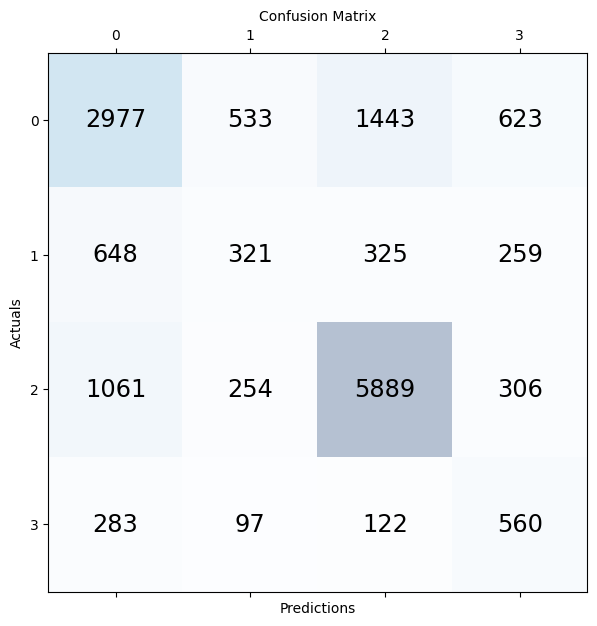

In [24]:
l1_svc = LinearSVC(penalty='l1', dual=False, random_state=42)
model= LinearSVC(class_weight='balanced',random_state=42)

# Create a pipeline with feature selection and classification steps
pipeline = Pipeline([
    ('feature_selection', SelectFromModel(estimator=l1_svc)),
    ('classifier', model)
])

all_true_labels, all_predicted_labels = cross_validate_with_pipeline(pipeline, X_train_embeddings, y_train, n_splits=5)
plot_confusion_matrix_and_report(all_true_labels, all_predicted_labels, class_labels=[0, 1, 2, 3])

In [25]:
# Initialize the LinearSVC model with L1 regularization for feature selection
l1_svc = LinearSVC(penalty='l1', dual=False, random_state=42)

# Create a pipeline with feature selection and classification steps
pipeline = Pipeline([
    ('feature_selection', SelectFromModel(estimator=l1_svc)),
    ('classifier', LinearSVC(random_state=42, class_weight='balanced'))
])

# Define cross-validation strategy (e.g., StratifiedKFold with 5 folds)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grids,
    n_iter=50,  
    scoring='f1_macro', 
    cv=kf,
    n_jobs=-1, 
    random_state=42,
    verbose=3
)

random_search.fit(X_train_embeddings, y_train)
best_model = random_search.best_estimator_
best_params = random_search.best_params_
best_score= random_search.best_score_

print("Best mean cross-validation f1-score: {:.3f}".format(best_score))
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best mean cross-validation f1-score: 0.491
Best Hyperparameters: {'classifier__penalty': 'l2', 'classifier__max_iter': 4000, 'classifier__loss': 'squared_hinge', 'classifier__dual': False, 'classifier__C': 1.0}


In [26]:
best_model.named_steps['classifier']

LinearSVC(class_weight='balanced', dual=False, max_iter=4000, random_state=42)

In [29]:
best_model.named_steps['feature_selection']

SelectFromModel(estimator=LinearSVC(dual=False, penalty='l1', random_state=42))

Fold number: 1, Training F1 Macro: 0.5586, Validation F1 Macro: 0.4935
Fold number: 2, Training F1 Macro: 0.5562, Validation F1 Macro: 0.4808
Fold number: 3, Training F1 Macro: 0.5560, Validation F1 Macro: 0.4885
Fold number: 4, Training F1 Macro: 0.5621, Validation F1 Macro: 0.4841
Fold number: 5, Training F1 Macro: 0.5539, Validation F1 Macro: 0.5091

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.60      0.53      0.56      5576
     Class 1       0.27      0.21      0.23      1553
     Class 2       0.76      0.78      0.77      7510
     Class 3       0.32      0.53      0.40      1062

    accuracy                           0.62     15701
   macro avg       0.49      0.51      0.49     15701
weighted avg       0.62      0.62      0.62     15701

Confusion Matrix:


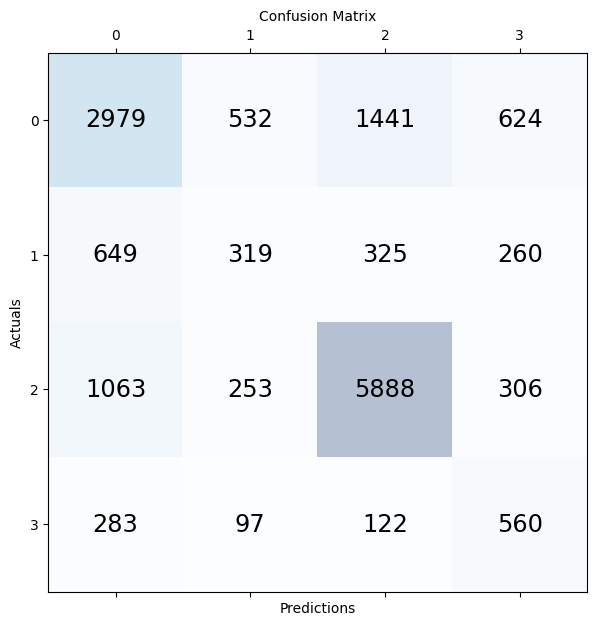

In [30]:
# Create a pipeline with feature selection and classification steps
pipeline = Pipeline([
    ('feature_selection', best_model.named_steps['feature_selection']),
    ('classifier', best_model.named_steps['classifier'])
])

all_true_labels, all_predicted_labels = cross_validate_with_pipeline(pipeline, X_train_embeddings, y_train, n_splits=5)
plot_confusion_matrix_and_report(all_true_labels, all_predicted_labels, class_labels=[0, 1, 2, 3])